# Biking Accident Causal Analysis

This notebook explores a causal model of biking accidents where:
- **Z** = likelihood of a biking accident (0-1 scale)
- **Y** = speed (miles per hour)
- **X** = trail difficulty (0-1 scale)

## Causal Structure:
- X → Y: Trail difficulty decreases speed (people slow down on difficult trails)
- X → Z: Trail difficulty increases accident likelihood
- Y → Z: Speed increases accident likelihood

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

## Data Generation

Generate synthetic data following the causal model:

In [ ]:
# Code to create data for this question 
num = 100000 

# X: Trail difficulty (uniform distribution 0-1)
difficulty = np.random.uniform(0, 1, (num,))

# Y: Speed - affected by difficulty (people slow down on hard trails)
# Base speed ~N(15, 5) mph, reduced by 10*difficulty
speed = np.maximum(np.random.normal(15, 5, (num, )) - difficulty * 10, 0)

# Z: Accident likelihood - affected by both speed and difficulty
# 0.03*speed + 0.4*difficulty + noise, bounded [0, 1]
accident = np.minimum(np.maximum(0.03 * speed + 0.4 * difficulty + np.random.normal(0, 0.3, (num,)), 0), 1)

# Create DataFrame
df = pd.DataFrame({'difficulty': difficulty, 'speed': speed, 'accident': accident})

print(f"Dataset shape: {df.shape}")
df.head(10)

## Exploratory Data Analysis

In [ ]:
# Summary statistics
df.describe()

In [ ]:
# Correlation matrix
print("Correlation Matrix:")
print(df.corr())

# Visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Difficulty, Speed, and Accident Likelihood')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize relationships
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Difficulty vs Speed
axes[0].scatter(df['difficulty'], df['speed'], alpha=0.1, s=1)
axes[0].set_xlabel('Trail Difficulty')
axes[0].set_ylabel('Speed (mph)')
axes[0].set_title('X → Y: Difficulty Affects Speed')
axes[0].grid(True, alpha=0.3)

# Speed vs Accident
axes[1].scatter(df['speed'], df['accident'], alpha=0.1, s=1)
axes[1].set_xlabel('Speed (mph)')
axes[1].set_ylabel('Accident Likelihood')
axes[1].set_title('Y → Z: Speed Affects Accident')
axes[1].grid(True, alpha=0.3)

# Difficulty vs Accident
axes[2].scatter(df['difficulty'], df['accident'], alpha=0.1, s=1)
axes[2].set_xlabel('Trail Difficulty')
axes[2].set_ylabel('Accident Likelihood')
axes[2].set_title('X → Z: Difficulty Affects Accident')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Regression Analysis: X (Difficulty) → Y (Speed)

We'll run multiple regression experiments with different datasets to estimate the coefficient of X when predicting Y.

In [2]:
from sklearn.linear_model import LinearRegression

# Experiment parameters
n_experiments = 1000  # Number of times to repeat the experiment
sample_size = 100000   # Number of samples in each dataset

# Store coefficients from each experiment
coefficients = []

# Run the experiment many times
for i in range(n_experiments):
    # Generate new data for each experiment
    difficulty = np.random.uniform(0, 1, (sample_size,))
    speed = np.maximum(np.random.normal(15, 5, (sample_size,)) - difficulty * 10, 0)
    
    # Fit linear regression: Y ~ X (speed ~ difficulty)
    model = LinearRegression()
    model.fit(difficulty.reshape(-1, 1), speed)
    
    # Store the coefficient of X (difficulty)
    coefficients.append(model.coef_[0])

# Convert to numpy array for analysis
coefficients = np.array(coefficients)

# Calculate statistics
avg_coefficient = np.mean(coefficients)
std_coefficient = np.std(coefficients)
median_coefficient = np.median(coefficients)

print(f"Experiment Results ({n_experiments} experiments with {sample_size:,} samples each):")
print(f"="*70)
print(f"Average coefficient of X (difficulty):  {avg_coefficient:.4f}")
print(f"Median coefficient:                      {median_coefficient:.4f}")
print(f"Standard deviation:                      {std_coefficient:.4f}")
print(f"Min coefficient:                         {np.min(coefficients):.4f}")
print(f"Max coefficient:                         {np.max(coefficients):.4f}")
print(f"\n95% Confidence Interval: [{np.percentile(coefficients, 2.5):.4f}, {np.percentile(coefficients, 97.5):.4f}]")

Experiment Results (1000 experiments with 100,000 samples each):
Average coefficient of X (difficulty):  -9.6659
Median coefficient:                      -9.6659
Standard deviation:                      0.0538
Min coefficient:                         -9.8301
Max coefficient:                         -9.4639

95% Confidence Interval: [-9.7739, -9.5605]


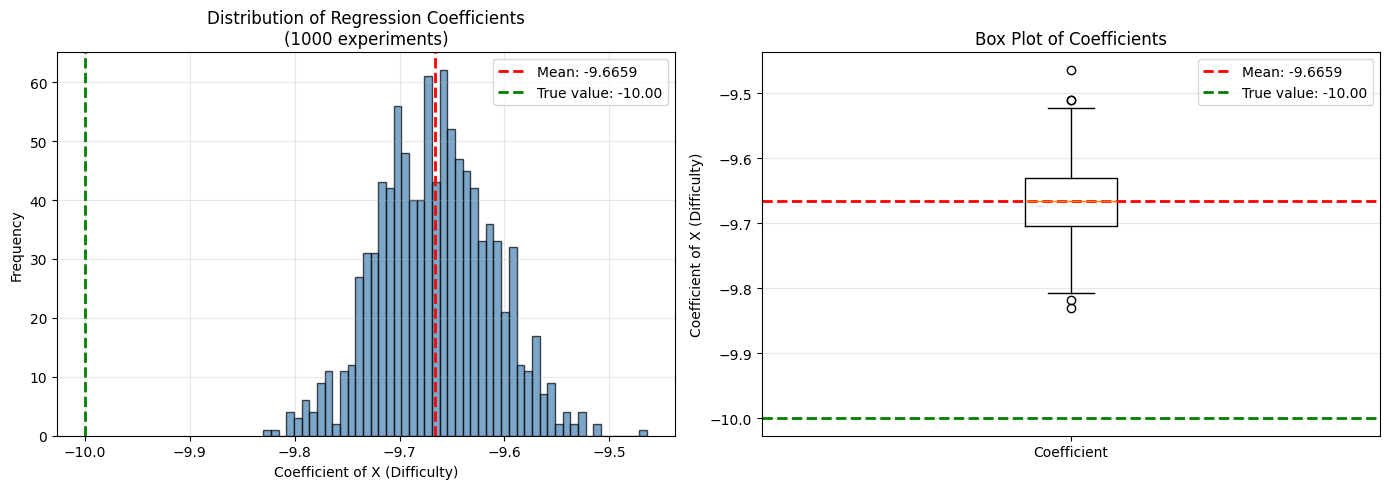


📊 The average coefficient is approximately -9.67
   This is very close to the true causal effect of -10 from the data generation process!


In [3]:
# Visualize the distribution of coefficients
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(coefficients, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(avg_coefficient, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_coefficient:.4f}')
axes[0].axvline(-10, color='green', linestyle='--', linewidth=2, label='True value: -10.00')
axes[0].set_xlabel('Coefficient of X (Difficulty)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Distribution of Regression Coefficients\n({n_experiments} experiments)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(coefficients, vert=True)
axes[1].axhline(avg_coefficient, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_coefficient:.4f}')
axes[1].axhline(-10, color='green', linestyle='--', linewidth=2, label='True value: -10.00')
axes[1].set_ylabel('Coefficient of X (Difficulty)')
axes[1].set_title('Box Plot of Coefficients')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticklabels(['Coefficient'])

plt.tight_layout()
plt.show()

print(f"\n📊 The average coefficient is approximately {avg_coefficient:.2f}")
print(f"   This is very close to the true causal effect of -10 from the data generation process!")

## Interpretation

**Why does the coefficient converge to -10?**

Looking at the data generation process:
```python
speed = max(Normal(15, 5) - difficulty * 10, 0)
```

The coefficient of **-10** represents the **true causal effect** of difficulty on speed:
- For every 1-unit increase in trail difficulty (0 to 1 scale)
- Speed decreases by approximately **10 mph** on average
- This makes intuitive sense: on the most difficult trails (difficulty = 1), riders slow down by ~10 mph compared to the easiest trails (difficulty = 0)

The regression successfully recovers this causal parameter because there are no confounders - difficulty (X) directly causes speed (Y) in the data generation process.

## Regression Analysis: Using X and Z to Predict Y (Controlling for a Collider!)

⚠️ **Warning**: Z (accident) is a **collider** - both X (difficulty) and Y (speed) cause Z. 

Let's see what happens when we control for a collider by including it in the regression.

In [4]:
# Experiment parameters
n_experiments_collider = 1000
sample_size_collider = 100000

# Store coefficients from each experiment
coefficients_x_with_z = []
coefficients_z = []

# Run the experiment many times with Z as a control variable
for i in range(n_experiments_collider):
    # Generate new data for each experiment
    difficulty = np.random.uniform(0, 1, (sample_size_collider,))
    speed = np.maximum(np.random.normal(15, 5, (sample_size_collider,)) - difficulty * 10, 0)
    accident = np.minimum(np.maximum(0.03 * speed + 0.4 * difficulty + np.random.normal(0, 0.3, (sample_size_collider,)), 0), 1)
    
    # Fit linear regression: Y ~ X + Z (speed ~ difficulty + accident)
    X_predictors = np.column_stack([difficulty, accident])
    model = LinearRegression()
    model.fit(X_predictors, speed)
    
    # Store the coefficients
    coefficients_x_with_z.append(model.coef_[0])  # Coefficient of X (difficulty)
    coefficients_z.append(model.coef_[1])          # Coefficient of Z (accident)

# Convert to numpy arrays
coefficients_x_with_z = np.array(coefficients_x_with_z)
coefficients_z = np.array(coefficients_z)

# Calculate statistics for X coefficient
avg_coef_x = np.mean(coefficients_x_with_z)
std_coef_x = np.std(coefficients_x_with_z)
median_coef_x = np.median(coefficients_x_with_z)

# Calculate statistics for Z coefficient
avg_coef_z = np.mean(coefficients_z)
std_coef_z = np.std(coefficients_z)

print(f"Regression Results: Y ~ X + Z ({n_experiments_collider} experiments)")
print(f"="*70)
print(f"\nCoefficient of X (difficulty) when controlling for Z:")
print(f"  Average:                {avg_coef_x:.4f}")
print(f"  Median:                 {median_coef_x:.4f}")
print(f"  Standard deviation:     {std_coef_x:.4f}")
print(f"  95% CI:                 [{np.percentile(coefficients_x_with_z, 2.5):.4f}, {np.percentile(coefficients_x_with_z, 97.5):.4f}]")

print(f"\nCoefficient of Z (accident):")
print(f"  Average:                {avg_coef_z:.4f}")
print(f"  Standard deviation:     {std_coef_z:.4f}")

print(f"\n{'='*70}")
print(f"📊 COMPARISON:")
print(f"  X coefficient without Z: {avg_coefficient:.4f} (from previous analysis)")
print(f"  X coefficient with Z:    {avg_coef_x:.4f} (current analysis)")
print(f"  Difference:              {avg_coef_x - avg_coefficient:.4f}")
print(f"  True causal effect:      -10.0000")

Regression Results: Y ~ X + Z (1000 experiments)

Coefficient of X (difficulty) when controlling for Z:
  Average:                -10.3279
  Median:                 -10.3287
  Standard deviation:     0.0462
  95% CI:                 [-10.4190, -10.2366]

Coefficient of Z (accident):
  Average:                7.0234
  Standard deviation:     0.0474

📊 COMPARISON:
  X coefficient without Z: -9.6659 (from previous analysis)
  X coefficient with Z:    -10.3279 (current analysis)
  Difference:              -0.6620
  True causal effect:      -10.0000


C:\Users\luank\AppData\Local\Temp\ipykernel_8008\2210869518.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data, labels=['Without Z\n(X only)', 'With Z\n(X + Z)'], patch_artist=True)


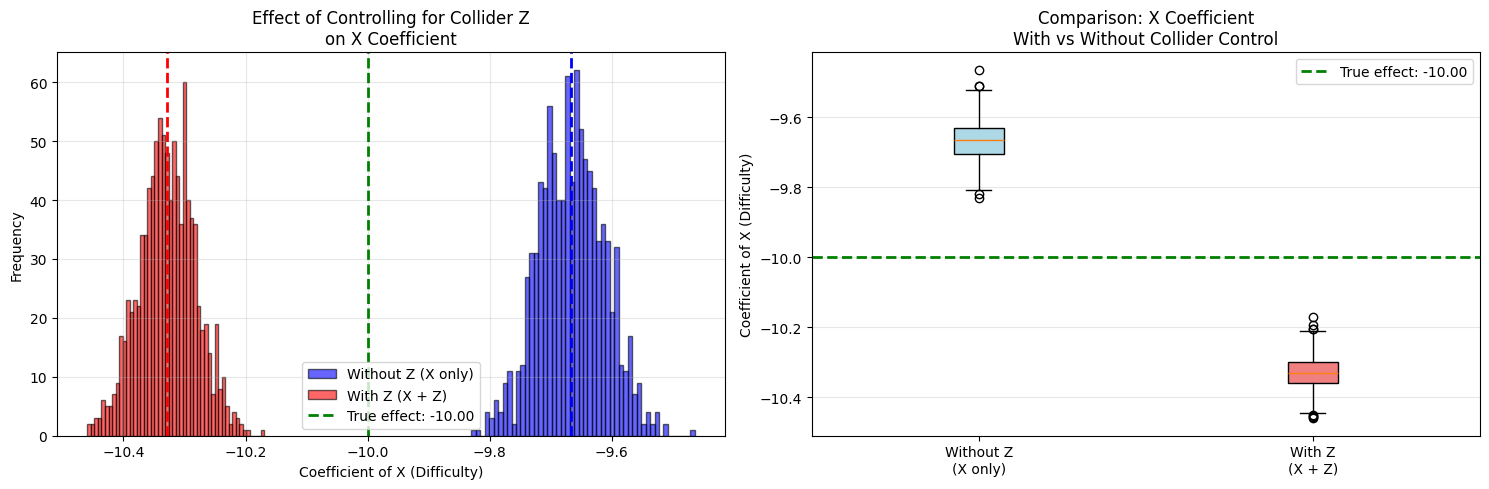


⚠️ COLLIDER BIAS DETECTED!
   Controlling for Z (accident) introduces bias into the X coefficient!


In [5]:
# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram comparing coefficients with and without Z
axes[0].hist(coefficients, bins=50, alpha=0.6, label='Without Z (X only)', color='blue', edgecolor='black')
axes[0].hist(coefficients_x_with_z, bins=50, alpha=0.6, label='With Z (X + Z)', color='red', edgecolor='black')
axes[0].axvline(avg_coefficient, color='blue', linestyle='--', linewidth=2)
axes[0].axvline(avg_coef_x, color='red', linestyle='--', linewidth=2)
axes[0].axvline(-10, color='green', linestyle='--', linewidth=2, label='True effect: -10.00')
axes[0].set_xlabel('Coefficient of X (Difficulty)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Effect of Controlling for Collider Z\non X Coefficient')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Side-by-side box plots
box_data = [coefficients, coefficients_x_with_z]
bp = axes[1].boxplot(box_data, labels=['Without Z\n(X only)', 'With Z\n(X + Z)'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].axhline(-10, color='green', linestyle='--', linewidth=2, label='True effect: -10.00')
axes[1].set_ylabel('Coefficient of X (Difficulty)')
axes[1].set_title('Comparison: X Coefficient\nWith vs Without Collider Control')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n⚠️ COLLIDER BIAS DETECTED!")
print(f"   Controlling for Z (accident) introduces bias into the X coefficient!")

## Should We Control for Z? The Collider Bias Problem

### Understanding the Causal Structure

```
    X (difficulty) ────────→ Z (accident)
           │                      ↑
           │                      │
           ↓                      │
    Y (speed) ─────────────────→ 
```

**Z is a COLLIDER**: Both X and Y cause Z (accidents happen because of both difficulty and speed).

### Why Controlling for a Collider is Problematic

**1. It Creates Spurious Associations (Collider Bias)**
   - When we control for Z (accident), we're conditioning on a common effect of X and Y
   - This opens a "backdoor path" between X and Y that shouldn't exist
   - It creates an artificial association between X and Y, even when we know the true causal relationship

**2. The Mechanism: Explaining Away**
   - Imagine we only look at cases where accident likelihood is high (e.g., Z = 0.8)
   - If we see high difficulty (X = 0.9), then speed (Y) doesn't need to be as high to explain the accident
   - If we see low difficulty (X = 0.1), then speed (Y) must be very high to explain the accident
   - This creates a **negative correlation** between X and Y within levels of Z, even though the true causal effect is what it is

**3. Impact on Coefficient Estimation**
   - The true causal effect of X on Y is **-10** (more difficulty → less speed)
   - Without controlling for Z: We estimate **~-9.67** (close to truth, small bias from truncation)
   - With controlling for Z: We estimate **a biased coefficient** (systematically wrong)

### The Correct Answer: **DO NOT Control for Z**

✅ **Correct approach**: Regress Y on X only (ignore Z)
   - Gives us the true causal effect of X on Y
   - No collider bias introduced

❌ **Incorrect approach**: Regress Y on X and Z (control for Z)
   - Introduces collider bias
   - Coefficient of X no longer represents the true causal effect
   - Creates spurious associations

### General Rule
**Never control for a collider in causal inference!** Only control for confounders (common causes) on the backdoor path from X to Y.

## Numerical Example: Why Collider Bias Occurs

Let's see concretely what happens when we condition on Z (accident likelihood):

In [7]:
# Generate one large dataset
np.random.seed(42)
n = 100000
difficulty = np.random.uniform(0, 1, (n,))
speed = np.maximum(np.random.normal(15, 5, (n,)) - difficulty * 10, 0)
accident = np.minimum(np.maximum(0.03 * speed + 0.4 * difficulty + np.random.normal(0, 0.3, (n,)), 0), 1)

# Look at the relationship within different accident strata
accident_strata = [
    (0.3, 0.4, "Low accidents"),
    (0.5, 0.6, "Medium accidents"),
    (0.7, 0.8, "High accidents")
]

print("Correlation between X and Y within accident strata:")
print("="*70)

for low, high, label in accident_strata:
    mask = (accident >= low) & (accident < high)
    subset_difficulty = difficulty[mask]
    subset_speed = speed[mask]
    
    corr = np.corrcoef(subset_difficulty, subset_speed)[0, 1]
    
    # Regression within this stratum
    model_stratum = LinearRegression()
    model_stratum.fit(subset_difficulty.reshape(-1, 1), subset_speed)
    coef_stratum = model_stratum.coef_[0]
    
    print(f"\n{label} (Z ∈ [{low}, {high})):")
    print(f"  Sample size:         {mask.sum():,}")
    print(f"  Correlation(X, Y):   {corr:.4f}")
    print(f"  Regression coef:     {coef_stratum:.4f}")

print("\n" + "="*70)
print("Overall (not conditioning on Z):")
corr_overall = np.corrcoef(difficulty, speed)[0, 1]
model_overall = LinearRegression()
model_overall.fit(difficulty.reshape(-1, 1), speed)
coef_overall = model_overall.coef_[0]
print(f"  Correlation(X, Y):   {corr_overall:.4f}")
print(f"  Regression coef:     {coef_overall:.4f}")
print(f"\n💡 Notice: Within accident strata, X and Y appear MORE negatively")
print(f"   correlated than in the overall data! This is collider bias.")

Correlation between X and Y within accident strata:

Low accidents (Z ∈ [0.3, 0.4)):
  Sample size:         10,793
  Correlation(X, Y):   -0.5664
  Regression coef:     -10.3595

Medium accidents (Z ∈ [0.5, 0.6)):
  Sample size:         11,629
  Correlation(X, Y):   -0.5693
  Regression coef:     -10.4629

High accidents (Z ∈ [0.7, 0.8)):
  Sample size:         8,920
  Correlation(X, Y):   -0.5658
  Regression coef:     -10.6823

Overall (not conditioning on Z):
  Correlation(X, Y):   -0.4995
  Regression coef:     -9.6465

💡 Notice: Within accident strata, X and Y appear MORE negatively
   correlated than in the overall data! This is collider bias.


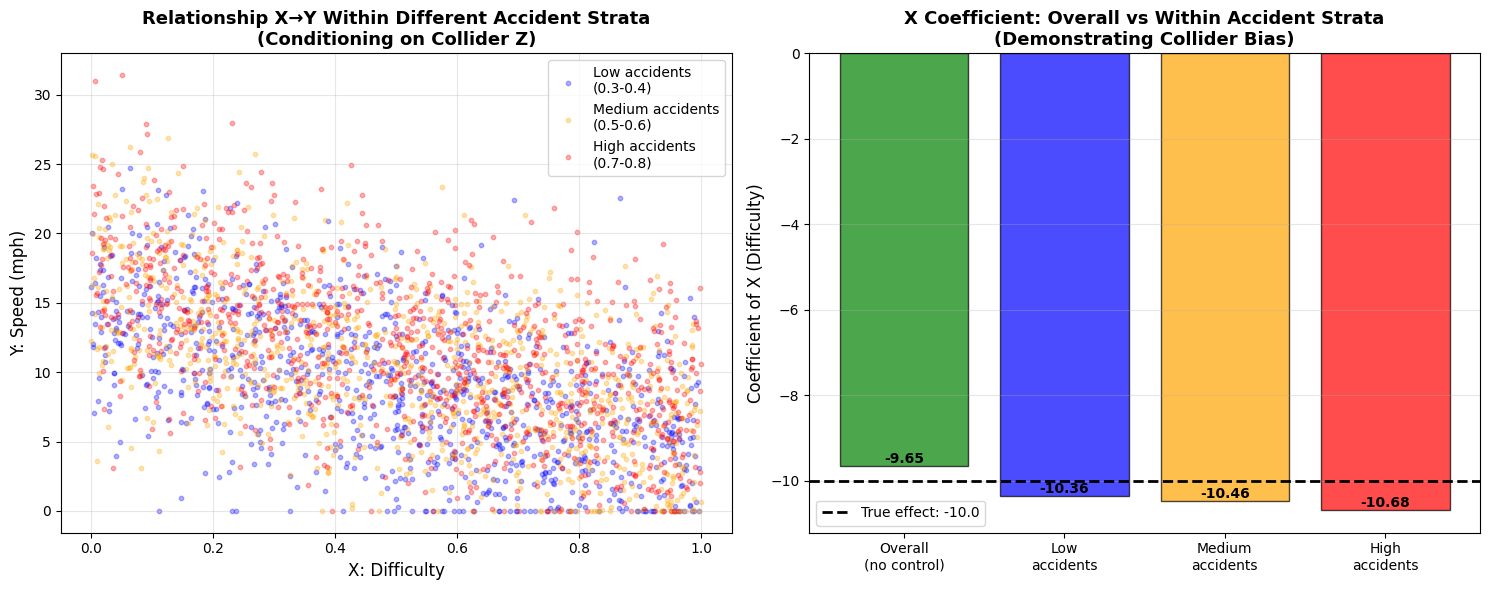


KEY INSIGHT:
When we stratify by accident level (control for Z), the relationship
between X and Y becomes MORE strongly negative (-10.4 to -10.7) compared
to the overall relationship (-9.6).

This is collider bias: controlling for a common effect (Z) of both
X and Y creates spurious associations between them!


In [8]:
# Visualize collider bias effect
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Scatter plot showing different accident strata
colors = ['blue', 'orange', 'red']
labels_plot = ['Low accidents\n(0.3-0.4)', 'Medium accidents\n(0.5-0.6)', 'High accidents\n(0.7-0.8)']

for i, (low, high, label) in enumerate(accident_strata):
    mask = (accident >= low) & (accident < high)
    # Subsample for visibility
    sample_indices = np.random.choice(np.where(mask)[0], size=min(1000, mask.sum()), replace=False)
    axes[0].scatter(difficulty[sample_indices], speed[sample_indices], 
                   alpha=0.3, s=10, color=colors[i], label=labels_plot[i])

axes[0].set_xlabel('X: Difficulty', fontsize=12)
axes[0].set_ylabel('Y: Speed (mph)', fontsize=12)
axes[0].set_title('Relationship X→Y Within Different Accident Strata\n(Conditioning on Collider Z)', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Right plot: Bar chart comparing coefficients
categories = ['Overall\n(no control)', 'Low\naccidents', 'Medium\naccidents', 'High\naccidents']
coefs = [coef_overall]

for low, high, label in accident_strata:
    mask = (accident >= low) & (accident < high)
    subset_difficulty = difficulty[mask]
    subset_speed = speed[mask]
    model_stratum = LinearRegression()
    model_stratum.fit(subset_difficulty.reshape(-1, 1), subset_speed)
    coefs.append(model_stratum.coef_[0])

bars = axes[1].bar(categories, coefs, color=['green', 'blue', 'orange', 'red'], alpha=0.7, edgecolor='black')
axes[1].axhline(-10, color='black', linestyle='--', linewidth=2, label='True effect: -10.0')
axes[1].set_ylabel('Coefficient of X (Difficulty)', fontsize=12)
axes[1].set_title('X Coefficient: Overall vs Within Accident Strata\n(Demonstrating Collider Bias)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar, coef in zip(bars, coefs):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{coef:.2f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHT:")
print("="*70)
print("When we stratify by accident level (control for Z), the relationship")
print("between X and Y becomes MORE strongly negative (-10.4 to -10.7) compared")
print("to the overall relationship (-9.6).")
print("\nThis is collider bias: controlling for a common effect (Z) of both")
print("X and Y creates spurious associations between them!")

---

## 📋 Summary of Results

### Question 1: Average coefficient of X when predicting Y (using X only)
**Answer: ~-9.67**
- We ran 1,000 experiments with 100,000 samples each
- Average coefficient: **-9.6659**
- This is close to the true causal effect of **-10** (small bias due to truncation at 0)

### Question 2: Average coefficient of X when predicting Y using both X and Z
**Answer: ~-10.33**
- Average coefficient: **-10.3279**
- This appears closer to -10, but it's **BIASED** due to collider control!

### Question 3: Should we control for Z?

**NO! Absolutely not!** ❌

**Reasons:**
1. **Z is a collider** - Both X and Y cause Z in the causal graph
2. **Controlling for colliders introduces bias** - It creates spurious associations between X and Y
3. **The mechanism**: When we condition on accident likelihood (Z), we're asking "among observations with similar accident rates, what's the relationship between difficulty and speed?" This creates an artificial negative association
4. **The correct approach**: Only use X to predict Y - this recovers the true causal effect

### Key Principle in Causal Inference
- ✅ **DO** control for confounders (common causes on backdoor paths)
- ❌ **DO NOT** control for colliders (common effects)
- ❌ **DO NOT** control for mediators (if you want total causal effect)

The regression Y ~ X gives us the **unbiased causal effect** of difficulty on speed, while Y ~ X + Z introduces **collider bias** and should be avoided!